In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from pdftotextByPage import mining


<H3>문장들로 이뤄진 데이터 불러오기

In [2]:
train_data = pd.read_table('txtoutput.txt')

if (train_data.isnull().values.any() == 'True'):
    train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

train_data.columns


Index(['Chapter  :  Operating-System Structures (구조)'], dtype='object')

In [3]:
train_data

,Chapter : Operating-System Structures (구조)
0,Chapter : Operating-System Structures
1,운영체제 서비스 (Operating System Services)
2,운영체제 사용자 인터페이스 (User Operating System Interface)
3,시스템 콜 (System Calls)
4,시스템 콜 유형 (Types of System Calls)
...,...
396,ROM 또는 EPROM(Erasable Programmable ROM)에 있는 bo...
397,두 단계로 나눠지는 경우도 있음- ROM의 특정한 위치에 있는부트블록(boot bl...
398,GRUB(GRand Unified Bootloader) : Linux 시스템을 위...
399,커널이 적재되어 시스템이 실행(running)되게 된다


<h3> 열이름 지정

In [4]:
train_data.columns=['Document'] 
train_data[:5]

,Document
0,Chapter : Operating-System Structures
1,운영체제 서비스 (Operating System Services)
2,운영체제 사용자 인터페이스 (User Operating System Interface)
3,시스템 콜 (System Calls)
4,시스템 콜 유형 (Types of System Calls)


<h3>문장에서 명사 추출

In [5]:
from konlpy.tag import Okt

nounsLine = []
nouns=[]
Okt = Okt()

for i in range (len(train_data['Document'])):
                line = train_data['Document'][i]# 한 페이지 씩 읽어 옴
                nouns = Okt.nouns(line) #한 페이지에 있는 명사들 모두 nouns에 저장 (리스트)

                if len(nouns) == 0 : 
                    nounsLine.append(' ')
                    continue #명사 없을 경우 ' ' 저장 후 pass
                line= ' '.join(map(str, nouns))
                nounsLine.append(line)
nounsLine
train_data['tokenizedDocument'] = nounsLine

<h3>결측값 제거

In [6]:
indexing = train_data[train_data['tokenizedDocument'] == ' '].index
train_data = train_data.drop(indexing)

<h2>토큰화

In [7]:
from tqdm import tqdm
from konlpy.tag import Okt

okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['tokenizedDocument']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    tokenized_data.append(tokenized_sentence)

100%|██████████| 346/346 [00:00<00:00, 1743.33it/s]


In [8]:
#토큰 화 된 전체 단어 수 확인
count = len(tokenized_data)
for i in range(len(tokenized_data)):
    count+=len(tokenized_data[i])
count

2102

<h1> Word2Vec 모델 사용 </h1>
<h6>1.size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.</h6>
<h6>2.window = 컨텍스트 윈도우 크기</h6>
<h6>3.min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)</h6>
<h6>4.workers = 학습을 위한 프로세스 수</h6>
<h6>5.sg = 0은 CBOW, 1은 Skip-gram.</h6>

In [9]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 3, min_count = 1, workers = 4, sg = 0)
model.wv.vectors.shape

(492, 100)

<h1>문장 벡터 계산

In [10]:
senVecs = [] # 문장 벡터 저장할 리스트
for i in range(len(tokenized_data)): # 데이터 길이 (문장 갯수 만큼 반복)
    senVecs.append(0) # 리스트에 0을 추가하고
    for j in range(len(tokenized_data[i])): # 각각 단어 벡터를 이용해 평균 벡터 추출, 문장 벡터 저장할 리스트에 가져옴
        senVecs[i] += (model.wv.get_vector(tokenized_data[i][j]))/len(tokenized_data[i])

<h3> senVecs에 저장된 벡터들은 배열 형태로 저장됨. 데이터 프레임에 넣기 위해 리스트 로 형변환 해주는 작업

In [11]:
#영벡터 처리 위해 만듦
blankVec = []
for i in range(100):
    blankVec.append(0)
blankVec

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [12]:
veclist = [] #리스트로 변환된 벡터들 여기에 담음
for i in range(len(senVecs)):
    if (type(senVecs[i]) == int):
        veclist.append(blankVec) #영벡터 처리
        continue
    veclist.append(list(senVecs[i]))

In [13]:
len(veclist[0]) # 차원 수와 같음

100

In [14]:
len(veclist) # 문장 수와 같음

346

<h1>dataframe에 벡터들 담을 열 생성 (100차원이므로 100개 생성)

In [15]:
dmCol = []    #차원 100개 맞춰 생성

for i in range(100):
    dmCol.append('dm%d'%(i+1)) # append로 요소 추가
 
dmCol

['dm1',
 'dm2',
 'dm3',
 'dm4',
 'dm5',
 'dm6',
 'dm7',
 'dm8',
 'dm9',
 'dm10',
 'dm11',
 'dm12',
 'dm13',
 'dm14',
 'dm15',
 'dm16',
 'dm17',
 'dm18',
 'dm19',
 'dm20',
 'dm21',
 'dm22',
 'dm23',
 'dm24',
 'dm25',
 'dm26',
 'dm27',
 'dm28',
 'dm29',
 'dm30',
 'dm31',
 'dm32',
 'dm33',
 'dm34',
 'dm35',
 'dm36',
 'dm37',
 'dm38',
 'dm39',
 'dm40',
 'dm41',
 'dm42',
 'dm43',
 'dm44',
 'dm45',
 'dm46',
 'dm47',
 'dm48',
 'dm49',
 'dm50',
 'dm51',
 'dm52',
 'dm53',
 'dm54',
 'dm55',
 'dm56',
 'dm57',
 'dm58',
 'dm59',
 'dm60',
 'dm61',
 'dm62',
 'dm63',
 'dm64',
 'dm65',
 'dm66',
 'dm67',
 'dm68',
 'dm69',
 'dm70',
 'dm71',
 'dm72',
 'dm73',
 'dm74',
 'dm75',
 'dm76',
 'dm77',
 'dm78',
 'dm79',
 'dm80',
 'dm81',
 'dm82',
 'dm83',
 'dm84',
 'dm85',
 'dm86',
 'dm87',
 'dm88',
 'dm89',
 'dm90',
 'dm91',
 'dm92',
 'dm93',
 'dm94',
 'dm95',
 'dm96',
 'dm97',
 'dm98',
 'dm99',
 'dm100']

In [16]:
df = pd.DataFrame(veclist, columns = dmCol) #dataframe으로 만듦
df

,dm1,dm2,dm3,dm4,dm5,dm6,dm7,dm8,dm9,dm10,...,dm91,dm92,dm93,dm94,dm95,dm96,dm97,dm98,dm99,dm100
0,-0.005363,-0.000512,0.007147,-0.001610,0.006108,-0.001265,0.000054,0.008724,0.002953,-0.006172,...,0.002862,-0.001767,0.004287,-0.007653,0.001113,0.002021,0.007376,0.001316,-0.001175,0.005756
1,-0.000630,0.002080,0.001856,-0.001423,0.002517,-0.002896,-0.001903,0.006140,-0.005848,-0.003149,...,0.002500,0.002282,0.003275,-0.001815,0.000834,0.003222,0.007290,-0.003162,0.001100,-0.003919
2,-0.003862,0.001073,-0.001253,0.003640,-0.002621,-0.001705,0.004142,0.006940,-0.005425,0.001427,...,0.003519,-0.001859,0.004261,-0.001774,0.006943,-0.001050,-0.000977,-0.001750,0.001026,0.004420
3,-0.002767,0.001186,-0.001221,0.001078,-0.001459,-0.004366,0.003231,0.003249,-0.005552,0.002219,...,0.005221,-0.000273,0.001127,-0.001968,0.006920,-0.002910,0.002440,-0.002243,-0.000867,0.001493
4,-0.004434,0.005097,0.002258,0.003769,-0.002179,-0.006612,0.004854,0.009221,-0.000331,-0.005905,...,-0.001859,-0.000062,0.001234,-0.000921,0.010356,0.002786,-0.001200,-0.007887,-0.000642,0.000139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.000650,0.000841,-0.000704,-0.003150,0.001503,-0.006730,-0.001161,0.007772,0.003788,-0.006122,...,0.002095,0.001415,0.002351,-0.003470,0.001670,0.002757,-0.004071,-0.003942,-0.002429,0.003343
342,0.005307,-0.001297,0.001391,0.000625,-0.000349,-0.003978,0.004232,0.001470,-0.003387,-0.001689,...,0.000073,-0.003719,-0.004412,0.002500,0.000399,-0.003744,-0.001741,-0.005637,0.000676,-0.006125
343,0.001275,0.001371,0.001448,-0.001155,0.000650,-0.002269,-0.000866,0.005654,-0.000950,0.000396,...,0.003081,-0.002327,0.000382,-0.000070,0.001456,-0.001879,-0.000852,-0.002582,-0.001587,-0.002540
344,-0.001683,0.003580,-0.001254,0.005246,0.001063,-0.003277,0.001220,0.003984,0.003013,-0.001263,...,0.002042,0.003508,-0.003454,0.000900,0.004378,-0.000311,-0.001045,-0.008586,0.003327,-0.001097


<h3> 문장과 해당 벡터를 파악할수 있도록 문장정보,벡터 한 데이터 프레임에 합치기

In [17]:
result3 = pd.concat([train_data.reset_index(drop=True),df.reset_index(drop=True)],axis=1) 
# train_Data(본 문장과 문장에서 토큰화 된 단어들 저장), df(벡터 저장) 
# reset_index(drop=True) - 병합 위해 각 데이터 프레임에서의 인덱스 초기화.
result3

,Document,tokenizedDocument,dm1,dm2,dm3,dm4,dm5,dm6,dm7,dm8,...,dm91,dm92,dm93,dm94,dm95,dm96,dm97,dm98,dm99,dm100
0,운영체제 서비스 (Operating System Services),운영체제 서비스,-0.005363,-0.000512,0.007147,-0.001610,0.006108,-0.001265,0.000054,0.008724,...,0.002862,-0.001767,0.004287,-0.007653,0.001113,0.002021,0.007376,0.001316,-0.001175,0.005756
1,운영체제 사용자 인터페이스 (User Operating System Interface),운영체제 사용자 인터페이스,-0.000630,0.002080,0.001856,-0.001423,0.002517,-0.002896,-0.001903,0.006140,...,0.002500,0.002282,0.003275,-0.001815,0.000834,0.003222,0.007290,-0.003162,0.001100,-0.003919
2,시스템 콜 (System Calls),시스템 콜,-0.003862,0.001073,-0.001253,0.003640,-0.002621,-0.001705,0.004142,0.006940,...,0.003519,-0.001859,0.004261,-0.001774,0.006943,-0.001050,-0.000977,-0.001750,0.001026,0.004420
3,시스템 콜 유형 (Types of System Calls),시스템 콜 유형,-0.002767,0.001186,-0.001221,0.001078,-0.001459,-0.004366,0.003231,0.003249,...,0.005221,-0.000273,0.001127,-0.001968,0.006920,-0.002910,0.002440,-0.002243,-0.000867,0.001493
4,시스템 프로그램 (System Programs),시스템 프로그램,-0.004434,0.005097,0.002258,0.003769,-0.002179,-0.006612,0.004854,0.009221,...,-0.001859,-0.000062,0.001234,-0.000921,0.010356,0.002786,-0.001200,-0.007887,-0.000642,0.000139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,운영체제를 하드웨어가 시작할 수 있도록 하드웨어에게 알려야 한다,운영체제 하드웨어 시작 수 하드웨어,0.000650,0.000841,-0.000704,-0.003150,0.001503,-0.006730,-0.001161,0.007772,...,0.002095,0.001415,0.002351,-0.003470,0.001670,0.002757,-0.004071,-0.003942,-0.002429,0.003343
342,ROM 또는 EPROM(Erasable Programmable ROM)에 있는 bo...,코드 커널 메모리 적재 커널 구동,0.005307,-0.001297,0.001391,0.000625,-0.000349,-0.003978,0.004232,0.001470,...,0.000073,-0.003719,-0.004412,0.002500,0.000399,-0.003744,-0.001741,-0.005637,0.000676,-0.006125
343,두 단계로 나눠지는 경우도 있음- ROM의 특정한 위치에 있는부트블록(boot bl...,두 단계 경우 의 위치 부트 블록 이 메모리 로드 것 디스크 부트스트랩 로더 메모리 적재,0.001275,0.001371,0.001448,-0.001155,0.000650,-0.002269,-0.000866,0.005654,...,0.003081,-0.002327,0.000382,-0.000070,0.001456,-0.001879,-0.000852,-0.002582,-0.001587,-0.002540
344,GRUB(GRand Unified Bootloader) : Linux 시스템을 위...,시스템 위 오픈소스 부트스트랩 프로그램,-0.001683,0.003580,-0.001254,0.005246,0.001063,-0.003277,0.001220,0.003984,...,0.002042,0.003508,-0.003454,0.000900,0.004378,-0.000311,-0.001045,-0.008586,0.003327,-0.001097


In [18]:
result3.to_csv('./final.csv')

In [19]:
# 한글 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
fontpath = 'C:/Windows/Fonts/malgun.ttf' # for Windows
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font)

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  


In [20]:
import matplotlib.pyplot as plt

# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(8 ,6))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

In [21]:
# 단어벡터를 구한다.
word_vectors = model.wv
# 벡터들의 키들
vocabs = word_vectors.key_to_index.keys()
# 벡터들
word_vectors_list = [word_vectors[v] for v in vocabs]

In [22]:
# type(vocabs)
print(vocabs)

dict_keys(['시스템', '운영체제', '사용자', '프로그램', '콜', '제공', '파일', '커널', '실행', '사용', '인터페이스', '메모리', '서비스', '프로세스', '계층', '구조', '정보', '생', '명령', '명령어', '구현', '다른', '관리', '장치', '적재', '등', '접근', '매개변수', '위', '전달', '모듈', '기능', '방법', '해석기', '하드웨어', '및', '를', '것', '종료', '기법', '수행', '자원', '코드', '설정', '통신', '오류', '정책', '언어', '일반', '가지', '이', '의', '은', '변경', '효율', '설계', '수', '각', '함', '분리', '성능', '컴퓨터', '선택', '상태', '공유', '디버깅', '일부', '종류', '목표', '위해', '입출력', '획득', '메시지', '유형', '구성', '대한', '환경', '프로그래밍', '시작', '윈도우', '속성', '대부분', '개발', '시간', '반환', '보안', '포함', '블록', '지원', '레지스터', '때', '스택', '시', '덤프', '위치', '공간', '쉘', '보호', '예', '로더', '부팅', '가능', '보장', '모든', '데', '업무', '간', '향상', '운영', '할당', '디렉토리', '파라미터', '비정상', '함수', '삭제', '라이브러리', '더', '집합', '정상', '제거', '연결', '입력', '다중', '단일', '대해', '디스크', '거나', '쓰기', '다수', '요청', '적', '여러', '개', '개발자', '경우', '결정', '셸', '필요', '모드', '마우스', '테이블', '가상', '호출', '고급', '로', '작성', '이식', '기록', '숫자', '내용', '마이크로커널', '부분', '하위', '기초', '모델', '작업', '최소', '단계', '찾기', '부착', '핵심', '

In [23]:
# 시각화를 위해 차원을 줄여보자.
# PCA로 차원을 축소해본다.
# 결과1 : 단어간 유사도를 확인
from sklearn.decomposition import PCA

# 주성분의 개수
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


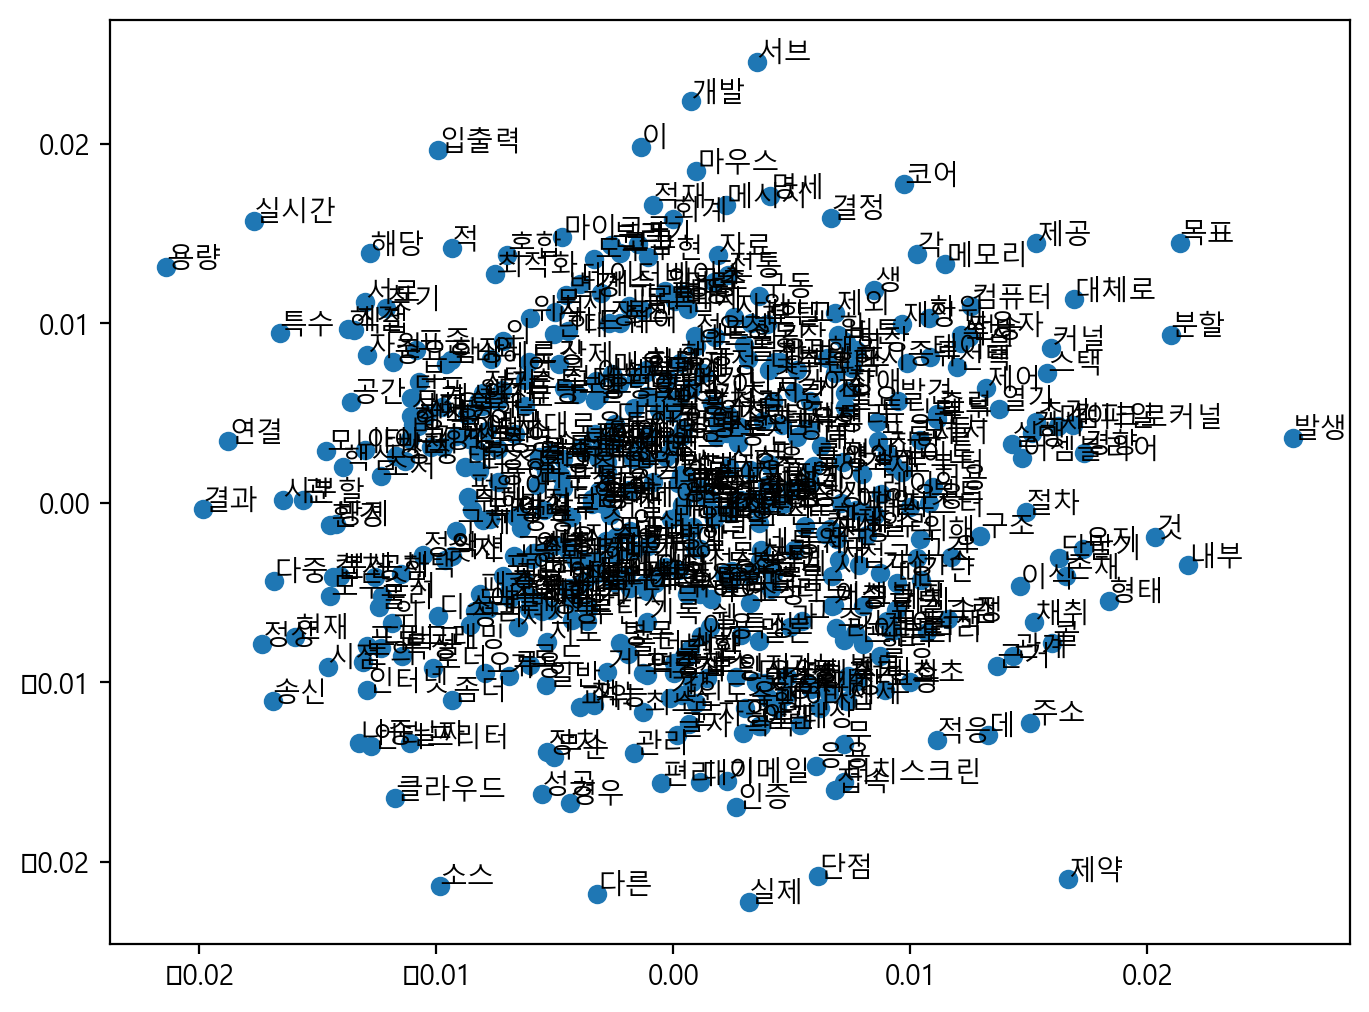

In [24]:
# https://ebbnflow.tistory.com/153
plot_2d_graph(vocabs, xs, ys)

c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


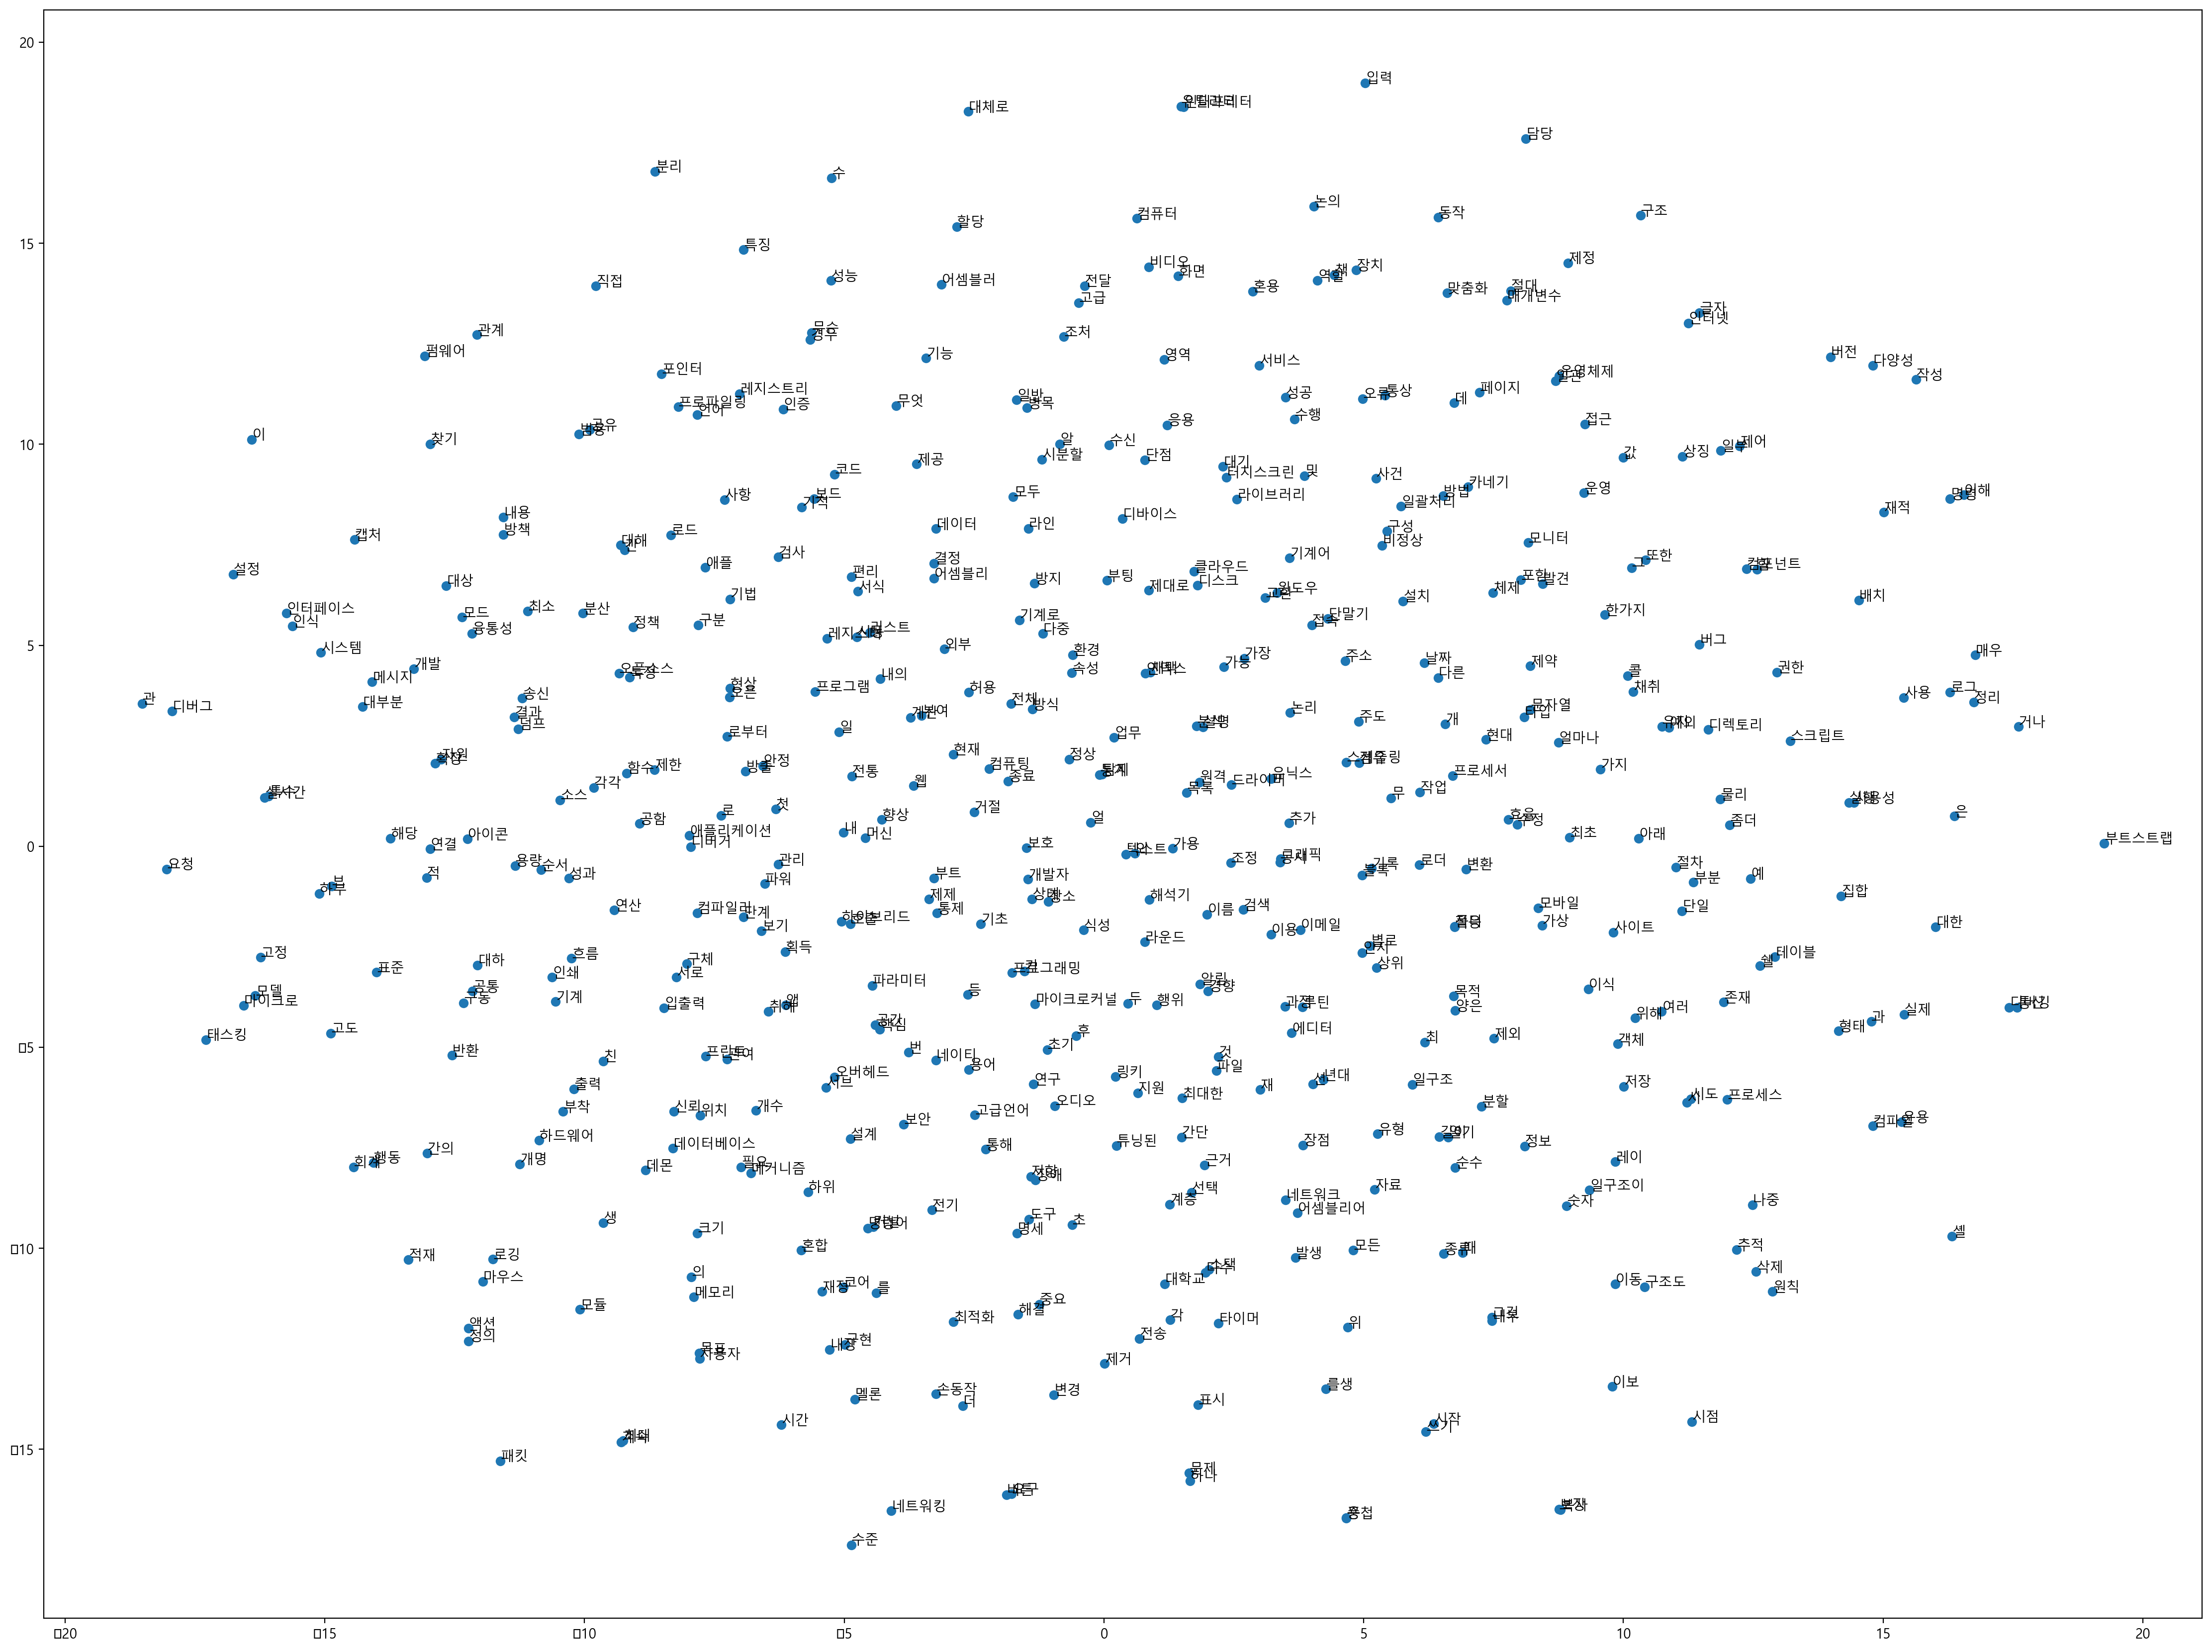

In [25]:
# https://comlini8-8.tistory.com/6
# 위의 그래프에서 모두 중간에 모여있는 것처럼 PCA는 군집의 변별력을 제대로 보존하지 못한다.
# t-SNE는 이러한 단점을 개선했다. 실제로 임베딩 결과는 t-SNE로 나타내는 경우가 많다.
from sklearn.manifold import TSNE

model2 = TSNE(learning_rate=100)
transformed = model2.fit_transform(word_vectors_list)

xs2 = transformed[:,0]
ys2 = transformed[:,1]

plt.figure(figsize=(28, 21))

plt.scatter(xs2, ys2)

for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs2[i], ys2[i]))